In [2]:
!pip install category_encoders==2.*

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Encoders
from category_encoders import OneHotEncoder, OrdinalEncoder

In [4]:
# Data paths via Github
train_path = 'https://raw.githubusercontent.com/attyfinch/spaceship_titanic_predictive_model_kaggle/main/spaceship-titanic/train.csv'
test_path = 'https://raw.githubusercontent.com/attyfinch/spaceship_titanic_predictive_model_kaggle/main/spaceship-titanic/test.csv'

In [13]:
def wrangle(path):
    df = pd.read_csv(path)

    # Fill blanks with NaN values
    df.replace(r'^\s*$', np.nan, regex=True)

    # Rename columns
    df.rename(columns={'PassengerId': 'id',
                       'HomePlanet': 'home_planet',
                       'CryoSleep': 'cryosleep',
                       'Cabin': 'cabin',
                       'Destination': 'destination',
                       'Age': 'age',
                       'VIP': 'vip',
                       'RoomService': 'room_service',
                       'FoodCourt': 'food_court',
                       'ShoppingMall': 'shopping_mall',
                       'Spa': 'spa',
                       'VRDeck': 'vr_deck',
                       'Transported': 'transported',
                      }, inplace=True)

    # Replacing NaN values
    df['home_planet'].fillna(df['home_planet'].mode()[0], inplace=True)
    df['cryosleep'].fillna(df['cryosleep'].mode()[0], inplace=True)
    df['cabin'].fillna(df['cabin'].mode()[0], inplace=True)
    df['destination'].fillna(df['destination'].mode()[0], inplace=True)
    df['age'].fillna(df['age'].median(), inplace=True)
    df['vip'].fillna(df['vip'].mode()[0], inplace=True)
    df['room_service'].fillna(df['room_service'].mode()[0], inplace=True)
    df['food_court'].fillna(df['food_court'].mode()[0], inplace=True)
    df['shopping_mall'].fillna(df['shopping_mall'].mode()[0], inplace=True)
    df['spa'].fillna(df['spa'].mode()[0], inplace=True)
    df['vr_deck'].fillna(df['vr_deck'].mode()[0], inplace=True)

    # Turn Bool columns into binary values
    df['cryosleep'] = df['cryosleep'].astype(int)
    df['vip'] = df['vip'].astype(int)
    df['transported'] = df['transported'].astype(int)

    # Drop columns due to various reasons, like HCCC
    df.drop(columns=['Name'], inplace=True)

    # deck, num, side features
    df['deck'] = df['cabin'].str.split('/', expand=True)[0]
    df['side'] = df['cabin'].str.split('/', expand=True)[2]
    df.drop(columns=['cabin'], inplace=True)

    # group number feature
    df['group_number'] = df['id'].str.split('_', expand=True)[0]
    df['group_number'] = df['group_number'].astype(int)

    group_df = (
        df.groupby(by='group_number')
        .agg(group_size = ('group_number', 'count'))
        .reset_index()
        )

    # inserting group size feature into df
    df = df.merge(group_df, on='group_number', how='left')
    df.drop(columns=['group_number'], inplace=True)

    df.set_index('id', inplace=True)
    return df

df = wrangle(train_path)
df.head()

,home_planet,cryosleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,transported,deck,side,group_size
id,,,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,P,1
0002_01,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,S,1
0003_01,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,S,2
0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,S,2
0004_01,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,S,1


### Feature Engineering Notes

Yielded results
- Eliminating number column
- Splitting home + dest back into separate cols
- Breaking ammenities spend back into individual cols
- Keeping deck and side separate

Some possible updates to my current wrangle function:
- Add age brackets, and tune grouping numbers

# Split Data

In [16]:
target = 'transported'
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline

In [59]:
baseline_acc = y_train.value_counts(normalize=True).max()
print(f'Baseline Accuracy: {baseline_acc}')

Baseline Accuracy: 0.5033074489502445


# Tuning

n_estimators
max_depth
max_samples

0.7975848188614146


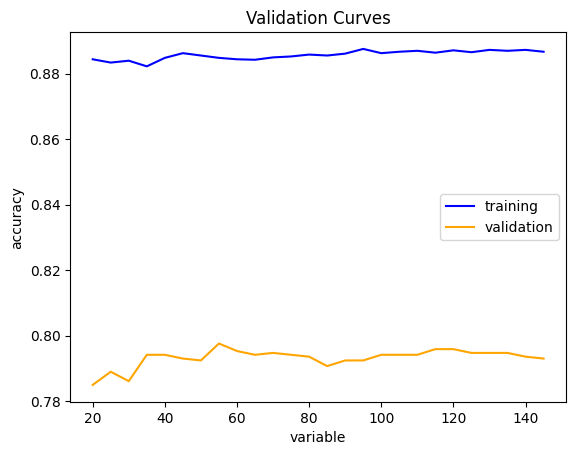

In [199]:
# Tuning individual variables
max_samples = np.arange(0.1, 1, 0.1)
max_depth = np.arange(2, 40, 2)
n_estimators = np.arange(20, 150, 5)

variable = n_estimators

train_acc = []
val_acc = []

for val in variable:
  model_tune = make_pipeline(
      # OrdinalEncoder(cols=['ship_loc']),
      OneHotEncoder(),
      StandardScaler(),
      RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=val, max_depth=12, max_samples=0.7)
  )
  model_tune.fit(X_train, y_train)
  train_acc.append(model_tune.score(X_train, y_train))
  val_acc.append(model_tune.score(X_test, y_test))

print(max(val_acc))
plt.plot(variable, train_acc, color='blue', label='training')
plt.plot(variable, val_acc, color='orange', label='validation')
plt.xlabel('variable')
plt.ylabel('accuracy')
plt.title('Validation Curves') # These plots are called VALIDATION CURVES!
plt.legend()
plt.show()

# Build Model + Check Metrics

In [17]:
# Base model I update with best params

model = make_pipeline(
    OneHotEncoder(),
    StandardScaler(),
    RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=55, max_depth=12, max_samples=0.7)
)

model.fit(X_train, y_train)

print('train score', model.score(X_train, y_train))
print('test score', model.score(X_test, y_test))

train score 0.8848144952545298
test score 0.7975848188614146


/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


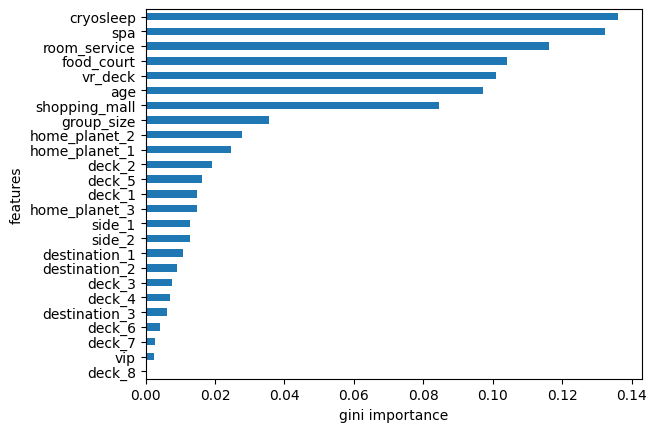

In [18]:
features = model.named_steps['onehotencoder'].get_feature_names()
gini_importances = model.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini_importances, index=features).sort_values(key=abs).tail(40).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');